#### Required Modules

In [1]:
import pandas as pd
from scipy.io import arff
import pycountry
import matplotlib.pyplot as plt

#### Load Datasets

In [2]:
# Expect a `data` directory
DATA_DIRECTORY = "./data/"

def load_from_arff(filename: str) -> pd.DataFrame:
    """
    Load ARFF data and build it into a Pandas DataFrame.
    """
    data, _ = arff.loadarff(DATA_DIRECTORY + filename)
    df = pd.DataFrame(data)
    return df

#### Dataset Selection

| Dataset | Description | Issues | Selected |
|---------|-------------|--------|----------|
| Poisonous Mushrooms | Manually compiled features of forages mushrooms. | No pre-processing required. | No |
| Airline Departure Delays | Time and location of flight departures. | No pre-processing required. | No |
| Mortgage Application Outcomes | Applicant information, application process results | All data is numeric with not keys for categories. Some categorical data is type `float`. | No |
| Wine Reviews | Reviews and ratings of wines from a specified location. | ARFF has format issues in `str` column. | **Yes** |

#### Wine Review Data

Libraries `scipy` and `liac-arff` fail to import the data.
SciPy complains it can not handle string columns, and LIAC-ARFF complains about the file format.

**Solution:** Manually reformatted file by rearranging ARFF features into a CSV column name row.

In [3]:
WINE_ARFF = "wine.arff"
WINE_CSV = "wine.csv"

# df = load_from_arff(WINE_ARFF)
df = pd.read_csv(DATA_DIRECTORY + WINE_CSV,
    sep=',',
    quotechar="'",
    escapechar='\\',
    engine='python',
    na_values='?')

df.head()

,country,description,points,price,province,variety
0,US,"This is a tight, black-fruited wine, with gene...",92,28.0,Washington,Cabernet Franc
1,US,A nice starter Pinot for the price. Will intro...,86,14.0,California,Pinot Noir
2,Spain,Raw aromas of rhubarb and scratchy raspberry o...,83,15.0,Northern Spain,Tempranillo
3,Germany,This wine comes out of the bottle a little cra...,90,18.0,Mosel-Saar-Ruwer,Riesling
4,South Africa,Winemaker: Jacques Borman. There's a ton of he...,90,NaN,Stellenbosch,Shiraz


In [4]:
df.describe()

,points,price
count,84123.000000,78545.000000
mean,88.533302,36.709084
std,3.092477,43.413841
min,80.000000,4.000000
25%,86.000000,18.000000
50%,88.000000,27.000000
75%,91.000000,45.000000
max,100.000000,3300.000000


In [5]:
null_counts = df.isnull().sum()
print(null_counts)

country          33
description       0
points            0
price          5578
province         33
variety           0
dtype: int64


#### Rename Columns

- Prepend the dataset name `WINE`.
- Replace spaces with underscores `_`.
- Add column type (whether it is `INPUT` or `LABEL`).
- Capitalize column names.

In [6]:
old_names = df.columns.tolist()
new_names = ["INPUT_" + name for name in old_names[:-1]] + ["LABEL_" + old_names[-1]]
new_names = ["WINE_" + name.upper() for name in new_names]
df.columns = new_names

#### Clean Location Columns

This is categorical data.
The country name will be replaced with a code 

In [7]:
country_column = 'WINE_EXTRA_COUNTRY'
df = df.rename(columns={'WINE_INPUT_COUNTRY': country_column})

def to_code(name: str) -> str:
    """
    Get country code from name.
    Replace '?' with None.
    """
    try:
        return pycountry.countries.lookup(name).alpha_2
    except LookupError:
        if name == "England":
            return "GB"
        elif name == "Turkey":
            return "TR"
        elif name == "Macedonia":
            return "MK"
        else:
            return None

code_column = "WINE_INPUT_CODE"
df[code_column] = df[country_column].apply(to_code)

Check no data was lost.

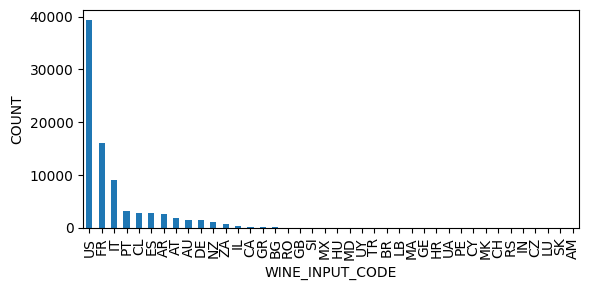

In [8]:
figure, axis = plt.subplots(
    # nrows=2,
    # ncols=1,
    # sharex=False,
    figsize=(6, 3))

# country_columns = [code_column, country_column]
# for ax, column in zip(axis, country_columns):
#     df[column].value_counts().plot(
#         kind='bar',
#         ax=ax,
#         rot=90)
#     ax.set_ylabel('Count')

df[code_column].value_counts().plot(
    kind='bar',
    ax=axis,
    rot=90)

axis.set_ylabel('COUNT')
plt.tight_layout()
plt.show()

Add column that track null rows in either location columns.

In [9]:
categorical_null = 'WINE_EXTRA_CATEGORICAL_IS_NULL'
province_column = 'WINE_INPUT_PROVINCE'
df[categorical_null] = df[code_column].isnull() | df[province_column].isnull()

print(
    'Null values in CATEGORICAL columns:',
    sum(df[categorical_null]))

Null values in CATEGORICAL columns: 33


#### Clean Numerical Column

In [10]:
points_column = "WINE_INPUT_POINTS"
price_column = "WINE_INPUT_PRICE"

print(
    'Null values in POINTS columns:',
    sum(df[points_column].isnull()))
print(
    'Null values in PRICE columns:',
    sum(df[price_column].isnull()))

Null values in POINTS columns: 0
Null values in PRICE columns: 5578


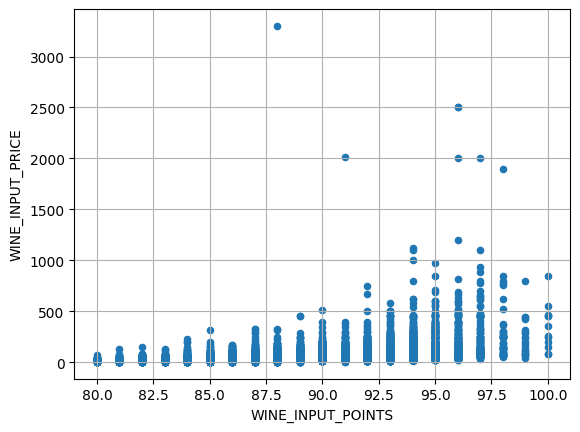

In [11]:
df.plot.scatter(
    x=points_column,
    y=price_column,
    s=20)

plt.grid(True)
plt.show()

Add column that track null rows in numerical columns.

In [12]:
numerical_null = 'WINE_EXTRA_NUMERICAL_IS_NULL'
province_column = 'WINE_INPUT_PROVINCE'
df[numerical_null] = df[points_column].isnull() | df[price_column].isnull()

print(
    'Null values in NUMERICAL columns:',
    sum(df[numerical_null]))

Null values in NUMERICAL columns: 5578


#### Review Text Features

This will require tokenization and further treatment with **NLTK** late on.

In [13]:
description_column = "WINE_INPUT_DESCRIPTION"
df[description_column].str.len().describe()

count    84123.000000
mean       243.192682
std         67.736085
min         24.000000
25%        197.000000
50%        238.000000
75%        284.000000
max        829.000000
Name: WINE_INPUT_DESCRIPTION, dtype: float64